In [1]:
# Importing dependecies
import pandas as pd
import json
import requests
from config import api_key
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Dictionary of series ID 
discretionary_dict = {
    'CXUFOODAWAYLB1101M': 'Food Away',
    'CXUAPPARELLB1101M': 'Apparel',
    'CXUENTRTAINLB1101M': 'Entertainment',
    'CXUCASHCONTLB1101M': 'Cash Contribution',
    'CXUALCBEVGLB1101M': 'Alcohol Beverages',
    'CXUEDUCATNLB1101M': 'Education',
    'CXUPERSCARELB1101M': 'Personal Care',
    'CXUTOBACCOLB1101M': 'Tobacco'
}

disposable_dict = {
     'CXUFOODHOMELB0401M': 'Food Home',
     'CXUHEALTHLB0401M': 'Health',
     'CXUHOUSINGLB0401M': 'Housing',
     'CXUTRANSLB0401M': 'Transport', 
}

In [3]:
# Description: Load the json response for the API queries
# Input: dictionary of seriesID - name key-value pairs
# Output: DataFrame to orgnanize the API query response
def json_df(dictionary):
    headers = {'Content-type': 'application/json'}
    data = json.dumps({"seriesid": list(dictionary.keys()),"startyear":"2005", "endyear":"2018","registrationkey":api_key})
    p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)
    json_data = json.loads(p.text)

    try:
        df = pd.DataFrame()

        # Loops through the json response to create a DataFrame
        for series in json_data['Results']['series']:
            # Create an initial DataFrame with column of Series IDs and dictionary of data
            df_initial = pd.DataFrame(series)
            series_col = df_initial['seriesID'][0]

            # Loops through the length of the initial DF to split up its second column
            for i in range(0, len(df_initial) - 1):
                df_row = pd.DataFrame(df_initial['data'][i])
                df_row['seriesID'] = series_col
                if 'code' not in str(df_row['footnotes']): 
                    df_row['footnotes'] = ''
                else:
                    df_row['footnotes'] = str(df_row['footnotes']).split("'code': '",1)[1][:1]
                df = df.append(df_row, ignore_index=True)

    except:
        json_data['status'] == 'REQUEST_NOT_PROCESSED'
        print('BLS API has given the following Response:', json_data['status'])
        print('Reason:', json_data['message'])
    return df

In [4]:
# Description: Computers the total of each series ID 
# Input: DataFrame created by calling json_df()
# Output: List of totals for each series ID
def get_total(df):
    # Initialize variables
    total = []
    dict_list = []
    i = 0
    
    # Convert the value column to float - a numeric data type will be needed to visualize the data
    df['value'] = df['value'].astype(float)
    
    series_set = set(df["seriesID"])
    for e in series_set:
        dict_list.append(e)
    
    dict_list = sorted(dict_list)
    
    # Loop through series list to create a list of the totals of each spending category
    for key in dict_list:
        # Append a value to a list to record the spending for each category
        total.append(int(df.groupby('seriesID')['value'].sum()[key]))

        # Counter
        i = i + 1
    return total

In [5]:
# Get the DataFrame for the discretionary expenditure series ID for all consumer units
df_discretionary = json_df(discretionary_dict)

# Get the total discretionary expenditure for each category 
total_discretionary = get_total(df_discretionary)

df_discretionary.head()

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,3459.0,,CXUFOODAWAYLB1101M
1,2017,A01,Annual,NaN,3365.0,,CXUFOODAWAYLB1101M
2,2016,A01,Annual,NaN,3154.0,,CXUFOODAWAYLB1101M
3,2015,A01,Annual,NaN,3008.0,,CXUFOODAWAYLB1101M
4,2014,A01,Annual,NaN,2787.0,,CXUFOODAWAYLB1101M


In [6]:
# Get the DataFrame for the disposable expenditure series ID for all consumer units
df_disposable = json_df(disposable_dict)

# Get the total disposable expenditure for each category 
total_disposable = get_total(df_disposable)

df_disposable.head()

,year,period,periodName,latest,value,footnotes,seriesID
0,2018,A01,Annual,true,4464.0,,CXUFOODHOMELB0401M
1,2017,A01,Annual,NaN,4363.0,,CXUFOODHOMELB0401M
2,2016,A01,Annual,NaN,4049.0,,CXUFOODHOMELB0401M
3,2015,A01,Annual,NaN,4015.0,,CXUFOODHOMELB0401M
4,2014,A01,Annual,NaN,3971.0,,CXUFOODHOMELB0401M


## Discretionary Spending Pie Chart (All Consumer Units)

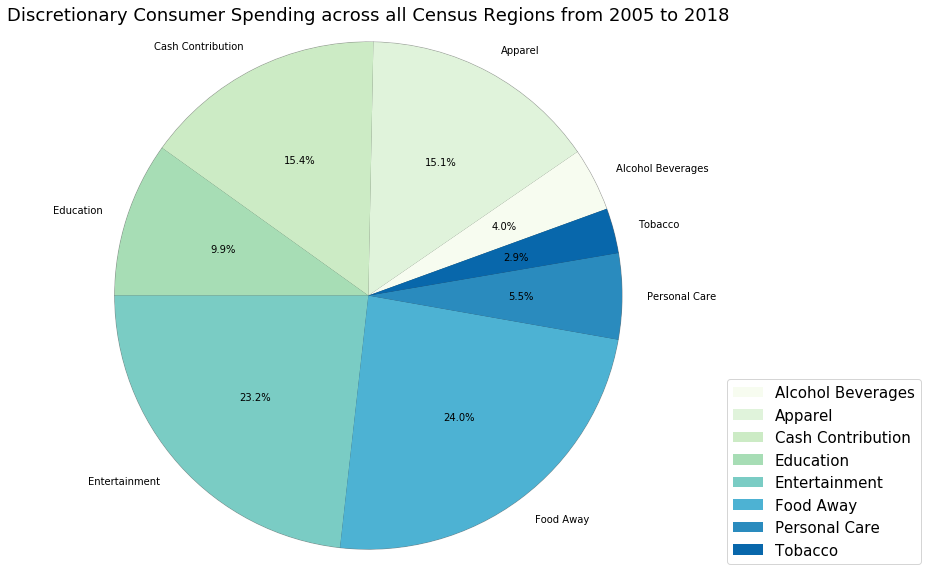

In [7]:
# Labels of the categories
discretionary_labels = sorted(list(discretionary_dict.values()))

# Don't explode any slice of the pie
explode = (0, 0, 0, 0, 0, 0, 0, 0)  

# Initialize figure and axis
fig1, ax1 = plt.subplots(figsize=(10,10))

# Create pie chart of the breakdown of discretionary spending
theme = plt.get_cmap("GnBu") #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax1.set_prop_cycle("color", [theme(1. * i / len(total_discretionary)) 
                             for i in range(len(total_discretionary))])
       
ax1.pie(total_discretionary, explode=explode, labels=discretionary_labels, autopct='%1.1f%%',
        shadow=True, startangle=20, radius=1800)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.rcParams['font.size'] = 15

plt.legend(
    loc='upper left',
    labels = discretionary_labels,
    bbox_to_anchor=(1, 0.4),
    bbox_transform=fig1.transFigure
)
plt.title('Discretionary Consumer Spending across all Census Regions from 2005 to 2018')
plt.xlabel('')
plt.ylabel('')

# Save figure
plt.savefig('Images/discretionary_spend.png')
plt.show()

## Disposable Spending Pie Chart (All Consumer Units)

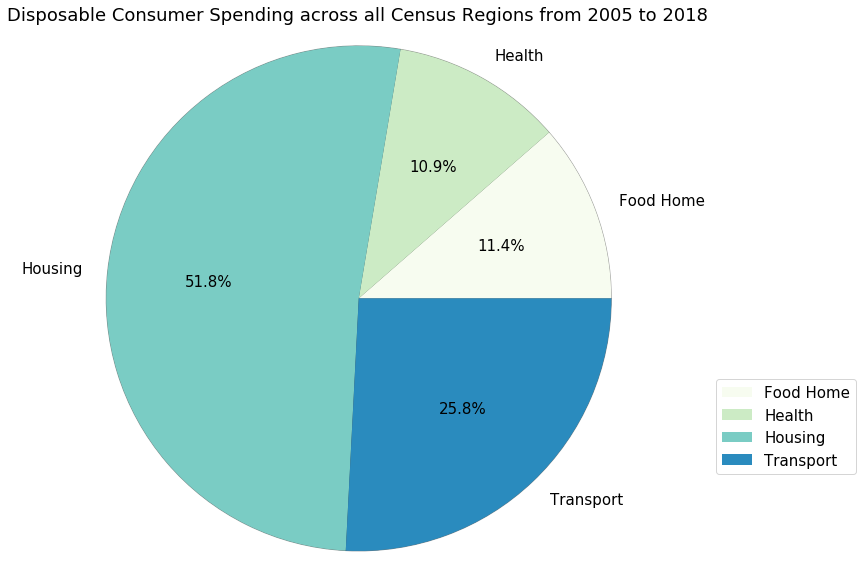

In [8]:
# Labels of the categories
disposable_labels = sorted(list(disposable_dict.values()))

# Don't explode any slice of the pie
explode = (0, 0, 0, 0)  

# Initialize figure and axis
fig1, ax1 = plt.subplots(figsize=(10,10))

# Create pie chart of the breakdown of discretionary spending
theme = plt.get_cmap("GnBu") #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax1.set_prop_cycle("color", [theme(1. * i / len(total_disposable))
                             for i in range(len(total_disposable))])
       
ax1.pie(total_disposable, explode=explode, labels=disposable_labels, autopct='%1.1f%%',
        shadow=True, startangle=0, radius=1800)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.rcParams['font.size'] = 15

plt.legend(
    loc='upper left',
    bbox_to_anchor=(1, 0.4),
    bbox_transform=fig1.transFigure
)
plt.title('Disposable Consumer Spending across all Census Regions from 2005 to 2018')
plt.xlabel('')
plt.ylabel('')

# Save figure
plt.savefig('Images/disposable_spend.png')
plt.show()

## 2009 Discretionary Spending Percent Change Analysis (Post Recession)

In [9]:
# Sort data by series ID and year
df_discretionary = df_discretionary.sort_values(['seriesID','year'], ascending = True).reset_index(drop=True)
df_discretionary

,year,period,periodName,latest,value,footnotes,seriesID
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M
...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M


In [10]:
# Get percent change over the years, grouped by series ID
df_discretionary['pct_decimal'] = df_discretionary.groupby(['seriesID'])['value'].pct_change()
df_discretionary['percent_change'] = df_discretionary['pct_decimal'].multiply(100)
df_discretionary

,year,period,periodName,latest,value,footnotes,seriesID,pct_decimal,percent_change
0,2006,A01,Annual,NaN,497.0,,CXUALCBEVGLB1101M,NaN,NaN
1,2007,A01,Annual,NaN,457.0,,CXUALCBEVGLB1101M,-0.080483,-8.048290
2,2008,A01,Annual,NaN,444.0,,CXUALCBEVGLB1101M,-0.028446,-2.844639
3,2009,A01,Annual,NaN,435.0,,CXUALCBEVGLB1101M,-0.020270,-2.027027
4,2010,A01,Annual,NaN,412.0,,CXUALCBEVGLB1101M,-0.052874,-5.287356
...,...,...,...,...,...,...,...,...,...
99,2014,A01,Annual,NaN,319.0,,CXUTOBACCOLB1101M,-0.033333,-3.333333
100,2015,A01,Annual,NaN,349.0,,CXUTOBACCOLB1101M,0.094044,9.404389
101,2016,A01,Annual,NaN,337.0,,CXUTOBACCOLB1101M,-0.034384,-3.438395
102,2017,A01,Annual,NaN,332.0,,CXUTOBACCOLB1101M,-0.014837,-1.483680


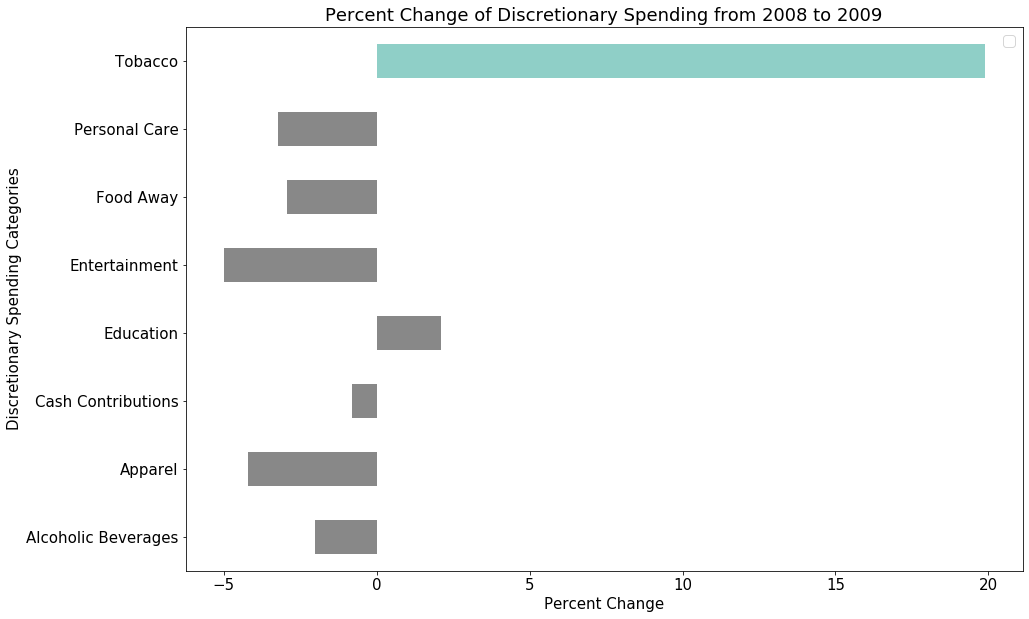

In [11]:
# Example python program to plot a horizontal bar chart
percent_chg_2009 = df_discretionary.loc[df_discretionary.year == '2009'][['seriesID','percent_change']]

dataFrame  = pd.DataFrame(data = percent_chg_2009)
colors = ["#888888","#888888","#888888","#888888","#888888","#888888","#888888","#8fcfc7"]
dataFrame.plot.barh(x='seriesID', 
                    y='percent_change', 
                    title="Percent Change of Discretionary Spending from 2008 to 2009",
                   color=colors, figsize=(15,10))

plt.yticks(np.arange(8), ("Alcoholic Beverages", 
                          "Apparel", 
                          "Cash Contributions", 
                          "Education", 
                          "Entertainment", 
                          "Food Away", 
                          "Personal Care", 
                          "Tobacco"))

plt.xlabel('Percent Change')
plt.ylabel('Discretionary Spending Categories')
plt.legend('')

# Save figure
plt.savefig('Images/2009_percent_change.png')
plt.show(block=True)

## Analysis: Spending % by Age
### Age Groups
Calling API Query to get discretionary spending based on age demographics

In [12]:
# Age 25-34 Characteristic Code: LB0402M
age25_dict = {
    'CXUFOODAWAYLB0402M': 'Food Away Under 25',
    'CXUAPPARELLB0402M': 'Apparel Under 25',
    'CXUENTRTAINLB0402M': 'Entertainment Under 25',
    'CXUCASHCONTLB0402M': 'Cash Contribution Under 25',
    'CXUALCBEVGLB0402M': 'Alcohol Under 25',
    'CXUEDUCATNLB0402M': 'Education Under 25',
    'CXUPERSCARELB0402M': 'Personal Care Under 25',
    'CXUTOBACCOLB0402M': 'Tobacco Under 25',
}
df_age25 = json_df(age25_dict) # Age under 25 DataFrame

# Age 25-34 Characteristic Code: LB0403M
age2534_dict = {
    'CXUFOODAWAYLB0403M': 'Food Away 25 to 34',
    'CXUAPPARELLB0403M': 'Apparel 25 to 34',
    'CXUENTRTAINLB0403M': 'Entertainment 25 to 34',
    'CXUCASHCONTLB0403M': 'Cash Contribution 25 to 34',
    'CXUALCBEVGLB0403M': 'Alcohol 25 to 34',
    'CXUEDUCATNLB0403M': 'Education 25 to 34',
    'CXUPERSCARELB0403M': 'Personal Care 25 to 34',
    'CXUTOBACCOLB0403M': 'Tobacco 25 to 34',  
}
df_age2534 = json_df(age2534_dict) # Age from 25 to 34 DataFrame

# Age 35-44 Characteristic Code: LB0404M
age3544_dict = {
    'CXUFOODAWAYLB0404M': 'Food Away 35 to 44',
    'CXUAPPARELLB0404M': 'Apparel 35 to 44',
    'CXUENTRTAINLB0404M': 'Entertainment 35 to 44',
    'CXUCASHCONTLB0404M': 'Cash Conttribution 35 to 44',
    'CXUALCBEVGLB0404M': 'Alcohol 35 to 44',
    'CXUEDUCATNLB0404M': 'Education 35 to 44',
    'CXUPERSCARELB0404M': 'Personal Care 35 to 44',
    'CXUTOBACCOLB0404M': 'Tobacco 35 to 44',
}
df_age3544 = json_df(age3544_dict) # Age from 35 to 44 DataFrame

# Age 45-54 Characteristic Code: LB0405M
age4554_dict = {
    'CXUFOODAWAYLB0405M': 'Food Away 45 to 54',
    'CXUAPPARELLB0405M': 'Apparel 45 to 54',
    'CXUENTRTAINLB0405M': 'Entertainment 45 to 54',
    'CXUCASHCONTLB0405M': 'Cash Contribution 45 to 54',
    'CXUALCBEVGLB0405M': 'Alcohol 45 to 54',
    'CXUEDUCATNLB0405M': 'Education 45 to 54',
    'CXUPERSCARELB0405M': 'Personal Care 45 to 54',
    'CXUTOBACCOLB0405M': 'Tobacco 45 to 54',
}
df_age4554 = json_df(age4554_dict) # Age from 45 to 54 DataFrame


# Age 55-64 Characteristic Code: LB0406M
age5564_dict = {
    'CXUFOODAWAYLB0406M': 'Food Away 55 to 64',
    'CXUAPPARELLB0406M': 'Apparel 55 to 64',
    'CXUENTRTAINLB0406M': 'Entertainment 55 to 64',
    'CXUCASHCONTLB0406M': 'Cash Contribution 55 to 64',
    'CXUALCBEVGLB0406M': 'Alcohol 55 to 64',
    'CXUEDUCATNLB0406M': 'Education 55 to 64',
    'CXUPERSCARELB0406M': 'Personal Care 55 to 64',
    'CXUTOBACCOLB0406MM': 'Tobacco 55 to 64',
}
df_age5564 = json_df(age5564_dict) # Age from 55 to 64 DataFrame

#Age Over 65 Characteristic Code: LB0407
age65_dict = {
    'CXUFOODAWAYLB0407M': 'Food Away Over 65',
    'CXUAPPARELLB0407M': 'Apparel Over 65',
    'CXUENTRTAINLB0407M': 'Entertainment Over 65',
    'CXUCASHCONTLB0407M': 'Cash Contribution Over 65',
    'CXUALCBEVGLB0407M': 'Alcohol Over 65',
    'CXUEDUCATNLB0407M': 'Education Over 65',
    'CXUPERSCARELB0407M': 'Personal Care Over 65',
    'CXUTOBACCOLB0407M': 'Tobacco Over 65',
}
df_age65 = json_df(age65_dict) # Age over 65 DataFrame

In [13]:
# Set list for each Age Group to store totals for each category (alphabetized)

# Grab Values for Age Groups
AgeUnder25 = get_total(df_age25)
Age25to34 = get_total(df_age2534)
Age35to44 = get_total(df_age3544)
Age45to54 = get_total(df_age4554)
Age55to64 = get_total(df_age5564)
Age64plus = get_total(df_age65)

age_totals = [AgeUnder25, Age25to34, Age35to44, Age45to54, Age55to64, Age64plus]
# No data for Tobacco for age groups 55 to 64

# AGE GROUP DF
name=['Under 25', '25 to 34', '35 to 44', '45 to 54', '55 to 64', "Over 65"]
age_df = pd.DataFrame(data=age_totals,
                      columns=discretionary_labels)
age_df["Age Group"] = name
age_df.set_index("Age Group", drop=True, inplace=True)
age_df

,Alcohol Beverages,Apparel,Cash Contribution,Education,Entertainment,Food Away,Personal Care,Tobacco
Age Group,,,,,,,,
Under 25,4654,17669,5793,27749,17727,26746,4836,3413.0
25 to 34,6999,25780,13199,12545,31887,38273,7426,4325.0
35 to 44,6952,29915,20530,13129,43257,45920,9749,4745.0
45 to 54,6982,28108,27481,29278,42955,44716,9961,5724.0
55 to 64,6624,22071,29545,14275,38840,35997,8759,NaN
Over 65,4356,13898,31218,3541,28299,25184,7430,2579.0


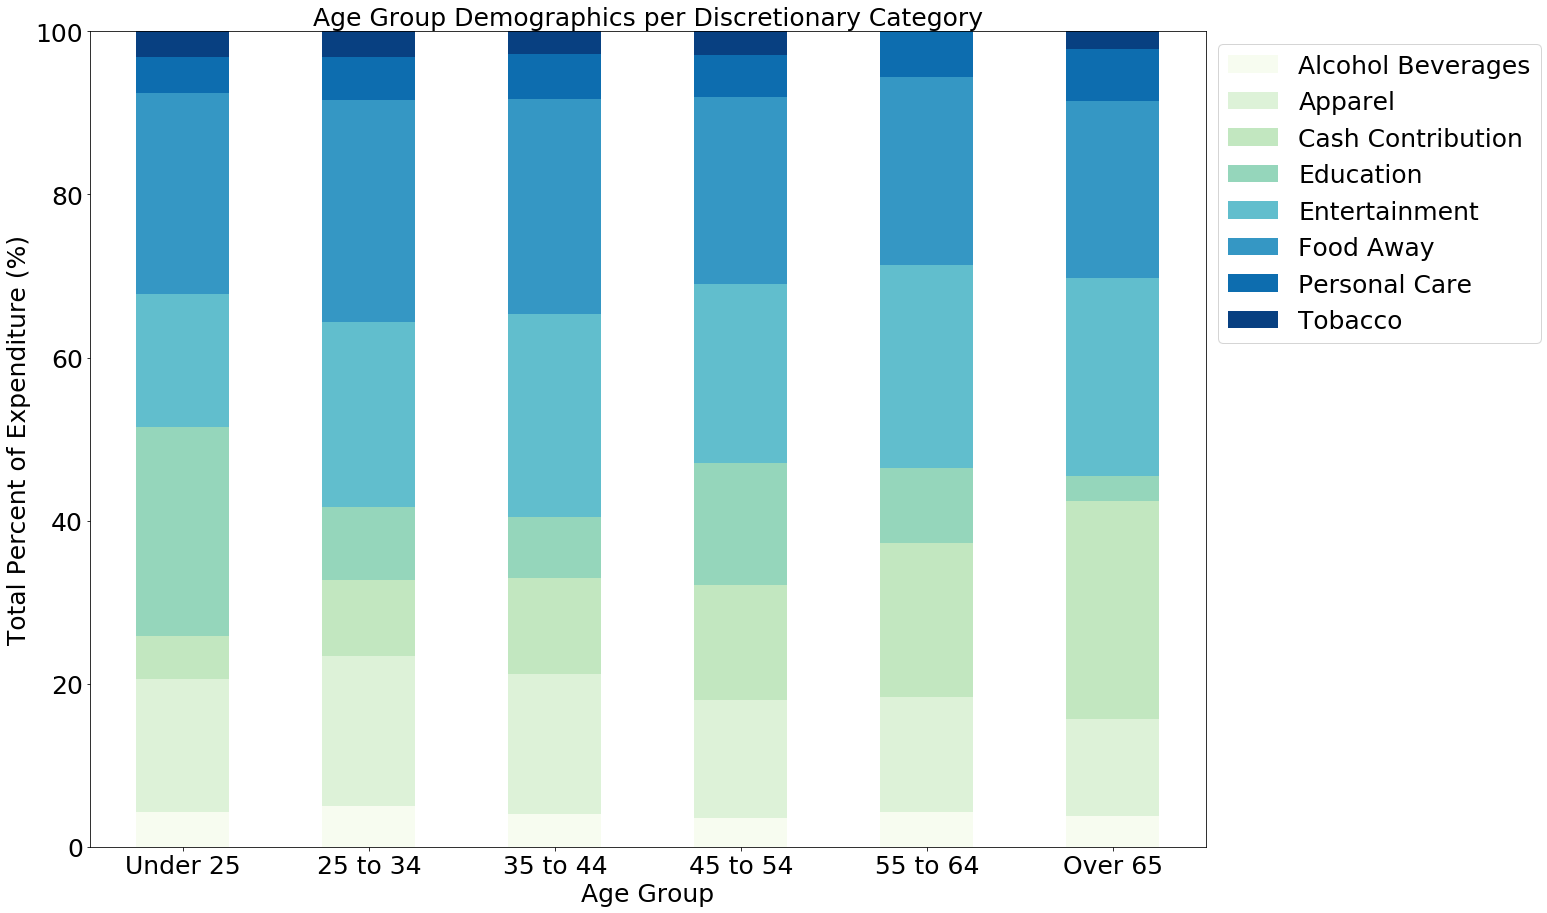

In [29]:
# Create stacked bar chart

# Compute the percentage 
age_df = age_df.div(age_df.sum(axis=1), axis=0) * 100

# Plot a stacked barchart
tocolor = (discretionary_labels)
colors = plt.get_cmap("GnBu", len(tocolor)) #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = age_df.plot.bar(stacked=True, figsize=(20,15), fontsize=25, colormap=colors)

# Place the legend
ax.legend(bbox_to_anchor=(1, 1), fontsize=25)
plt.xticks(rotation=0)
plt.ylim(0, 100) #CHANGE 100 TO 200000 FOR Y lABEL: VALUE ($)
plt.title('Age Group Demographics per Discretionary Category', fontsize=25)
plt.xlabel('Age Group', fontsize=25)
plt.ylabel('Total Percent of Expenditure (%)', fontsize=25)

# Save figure
plt.savefig('Images/spend_by_age.png')
plt.show()

## Analysis: Spending Amounts by Regions

### Geographic Regions
Calling API Query to get discretionary spending based on geographic region demographic

In [15]:
# Northeast Characteristic Code: LB1102M

ne_dict = {
    'CXUFOODAWAYLB1102M': 'Northeast Food Away',
    'CXUAPPARELLB1102M': 'Northeast Apparel',
    'CXUENTRTAINLB1102M': 'Northeast Entertainment',
    'CXUCASHCONTLB1102M': 'Northeast Cash Contribution',
    'CXUALCBEVGLB1102M': 'Northeast Alcohol Beverages',
    'CXUEDUCATNLB1102M': 'Northeast Education',
    'CXUPERSCARELB1102M': 'Northeast Personal Care',
    'CXUTOBACCOLB1102M': 'Northeast Tobacco'
}

ne_df = json_df(ne_dict) # Northeast DataFrame

In [16]:
# Midwest Characteristic Code: LB1103M

mw_dict = {
    'CXUFOODAWAYLB1103M': 'Midwest Food Away',
    'CXUAPPARELLB1103M': 'Midwest Apparel',
    'CXUENTRTAINLB1103M': 'Midwest Entertainment',
    'CXUCASHCONTLB1103M': 'Midwest Cash Contribution',
    'CXUALCBEVGLB1103M': 'Midwest Alcohol Beverages',
    'CXUEDUCATNLB1103M': 'Midwest Education',
    'CXUPERSCARELB1103M': 'Midwest Personal Care',
    'CXUTOBACCOLB1103M': 'Midwest Tobacco'
}

mw_df = json_df(mw_dict)

In [17]:
# Southern Characteristic Code: LB1104M

south_dict = {
    'CXUFOODAWAYLB1104M': 'Southern Food Away',
    'CXUAPPARELLB1104M': 'Southern Apparel',
    'CXUENTRTAINLB1104M': 'Southern Entertainment',
    'CXUCASHCONTLB1104M': 'Southern Cash Contribution',
    'CXUALCBEVGLB1104M': 'Southern Alcohol Beverages',
    'CXUEDUCATNLB1104M': 'Southern Education',
    'CXUPERSCARELB1104M': 'Southern Personal Care',
    'CXUTOBACCOLB1104M': 'Southern Tobacco'
}

south_df = json_df(south_dict)

In [18]:
# Western Characteristic Code: LB1105M
west_dict = {
    'CXUFOODAWAYLB1105M': 'Western Food Away',
    'CXUAPPARELLB1105M': 'Western Apparel',
    'CXUENTRTAINLB1105M': 'Western Entertainment',
    'CXUCASHCONTLB1105M': 'Western Cash Contribution',
    'CXUALCBEVGLB1105M': 'Western Alcohol Beverages',
    'CXUEDUCATNLB1105M': 'Western Education',
    'CXUPERSCARELB1105M': 'Western Personal Care',
    'CXUTOBACCOLB1105M': 'Western Tobacco'
}

west_df = json_df(west_dict)

In [19]:
# Set list for each Geo Group to store totals for each category

# Grab Values for Geo Groups
Northeast = get_total(ne_df) # Northeast totals
Midwest = get_total(mw_df)
South = get_total(south_df)
West = get_total(west_df)

geo_totals = [Northeast, Midwest, South, West]
# No data for Tobacco for age groups 55 to 64

# AGE GROUP DF
name = ['Northeast', 'Midwest', 'South', 'West']
geo_df = pd.DataFrame(data=geo_totals,
                      columns=discretionary_labels)
geo_df["Geo Group"] = name
geo_df.set_index("Geo Group", drop=True, inplace=True)
geo_df

,Alcohol Beverages,Apparel,Cash Contribution,Education,Entertainment,Food Away,Personal Care,Tobacco
Geo Group,,,,,,,,
Northeast,6884,25281,21921,22978,36073,38362,8530,4588
Midwest,6206,21623,23204,15107,35918,34573,7954,4930
South,5078,21521,22420,11229,32133,34610,7923,4644
West,7505,25854,27785,15515,41036,41741,9546,3336


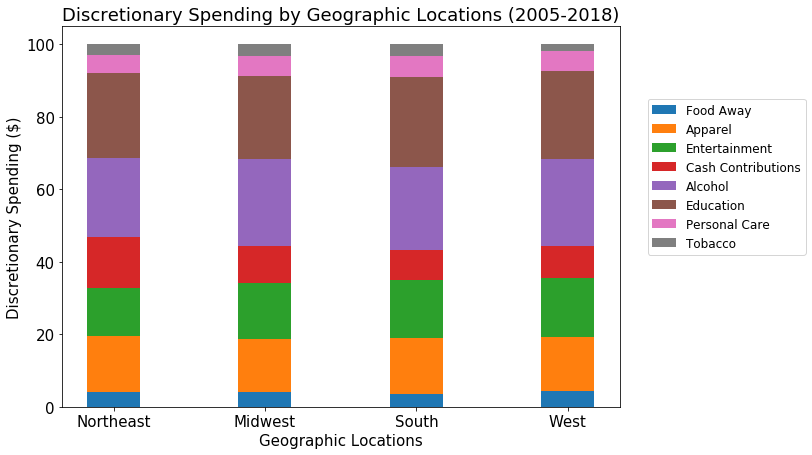

In [20]:
geo_df = geo_df.div(geo_df.sum(axis=1), axis=0) * 100

# Use iloc to grab the data from each of the columns, then label that data

food_away = geo_df.iloc[:,0]
apparel = geo_df.iloc[:,1]
entertainment = geo_df.iloc[:,2]
cash_contributions = geo_df.iloc[:,3]
alcohol_bev = geo_df.iloc[:,4]
education = geo_df.iloc[:,5]
personal_care = geo_df.iloc[:,6]
tobacco = geo_df.iloc[:,7]


# Create a variable for the index, which will generate the index for the graph
indx = np.arange(len(geo_df))

# Height needs to match what you're graphing, and last bottom matches the previous line's height
plt.figure(figsize= (10,7))

graphfaway = plt.bar(x=indx, height=food_away, width=0.35 , label = 'Food Away',)
graphapparel = plt.bar(x=indx, height=apparel, width=0.35, bottom = food_away, label = 'Apparel')
graphentertainment = plt.bar(x=indx, height=entertainment, width=0.35, bottom = food_away + apparel , label = 'Entertainment')
graphcashcont = plt.bar(x=indx, height=cash_contributions, width=0.35, bottom = food_away + apparel + entertainment , label = 'Cash Contributions')
graphalcohol = plt.bar(x=indx, height=alcohol_bev, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions, label = 'Alcohol')
grapheducation = plt.bar(x=indx, height=education, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions + alcohol_bev, label = 'Education')
graphperscare = plt.bar(x=indx, height=personal_care, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions + alcohol_bev + education, label = 'Personal Care')
graphtobacco = plt.bar(x=indx, height=tobacco, width=0.35, bottom = food_away + apparel + entertainment + cash_contributions + alcohol_bev + education + personal_care, label = 'Tobacco')


plt.xlabel('Geographic Locations')
plt.ylabel('Discretionary Spending ($)')

# Create the ticks

plt.xticks(indx,name)
plt.title('Discretionary Spending by Geographic Locations (2005-2018)')
plt.legend(fontsize = 12, loc = (1.05, 0.4))

# Save figure
plt.savefig('Images/spend_by_geo.png')
plt.show()

## Analysis: Spending % by Race
### Race Groups
Calling API Query to get discretionary spending based on race demographics

In [21]:
# 'Black or African-American' Characteristic Code: LB0905M
BAA_dict = {
    'CXUFOODAWAYLB0905M': 'Food Away from Home',
    'CXUAPPARELLB0905M': 'Apparel',
    'CXUENTRTAINLB0905M': 'Entertainment',
    'CXUCASHCONTLB0905M': 'Cash Contribution',
    'CXUALCBEVGLB0905M': 'Alcoholic Beverages',
    'CXUEDUCATNLB0905M': 'Education',
    'CXUPERSCARELB0905M': 'Personal Care',
    'CXUTOBACCOLB0905M': 'Tobacco',
}
df_BAA = json_df(BAA_dict) # 'Black or African-American' DataFrame

# 'Asian' Characteristic Code: LB0904M
ASN_dict = {
    'CXUFOODAWAYLB0904M': 'Food Away from Home',
    'CXUAPPARELLB0904M': 'Apparel',
    'CXUENTRTAINLB0904M': 'Entertainment',
    'CXUCASHCONTLB0904M': 'Cash Contribution',
    'CXUALCBEVGLB0904M': 'Alcoholic Beverages',
    'CXUEDUCATNLB0904M': 'Education',
    'CXUPERSCARELB0904M': 'Personal Care',
    'CXUTOBACCOLB0904M': 'Tobacco',  
}
df_ASN = json_df(ASN_dict) # 'Asian' DataFrame

# 'White and All Other Races' Characteristic Code: LB0903M
WAO_dict = {
    'CXUFOODAWAYLB0903M': 'Food Away from Home',
    'CXUAPPARELLB0903M': 'Apparel',
    'CXUENTRTAINLB0903M': 'Entertainment',
    'CXUCASHCONTLB0903M': 'Cash Conttribution',
    'CXUALCBEVGLB0903M': 'Alcoholic Beverages',
    'CXUEDUCATNLB0903M': 'Education',
    'CXUPERSCARELB0903M': 'Personal Care',
    'CXUTOBACCOLB0903M': 'Tobacco',
}
df_WAO = json_df(WAO_dict) # 'White and All Other Races' DataFrame

In [22]:
# Set list for each Age Group to store totals for each category (alphabetized)

# Grab Values for Age Groups
Black_AA = get_total(df_BAA)
Asian = get_total(df_ASN)
White_Others = get_total(df_WAO)

race_totals = [Black_AA, Asian, White_Others]

# AGE GROUP DF
name=['Black or African-American', 'Asian', 'White and All Other Races']
race_df = pd.DataFrame(data=race_totals,
                      columns=discretionary_labels)
race_df["Race Group"] = name
race_df.set_index("Race Group", drop=True, inplace=True)
race_df

,Alcohol Beverages,Apparel,Cash Contribution,Education,Entertainment,Food Away,Personal Care,Tobacco
Race Group,,,,,,,,
Black or African-American,2707,21265,16966,8997,19208,24079,7235,3087
Asian,4560,31663,19894,33924,31539,48904,8530,1849
White and All Other Races,6801,23072,24913,15174,38375,38204,8570,4732


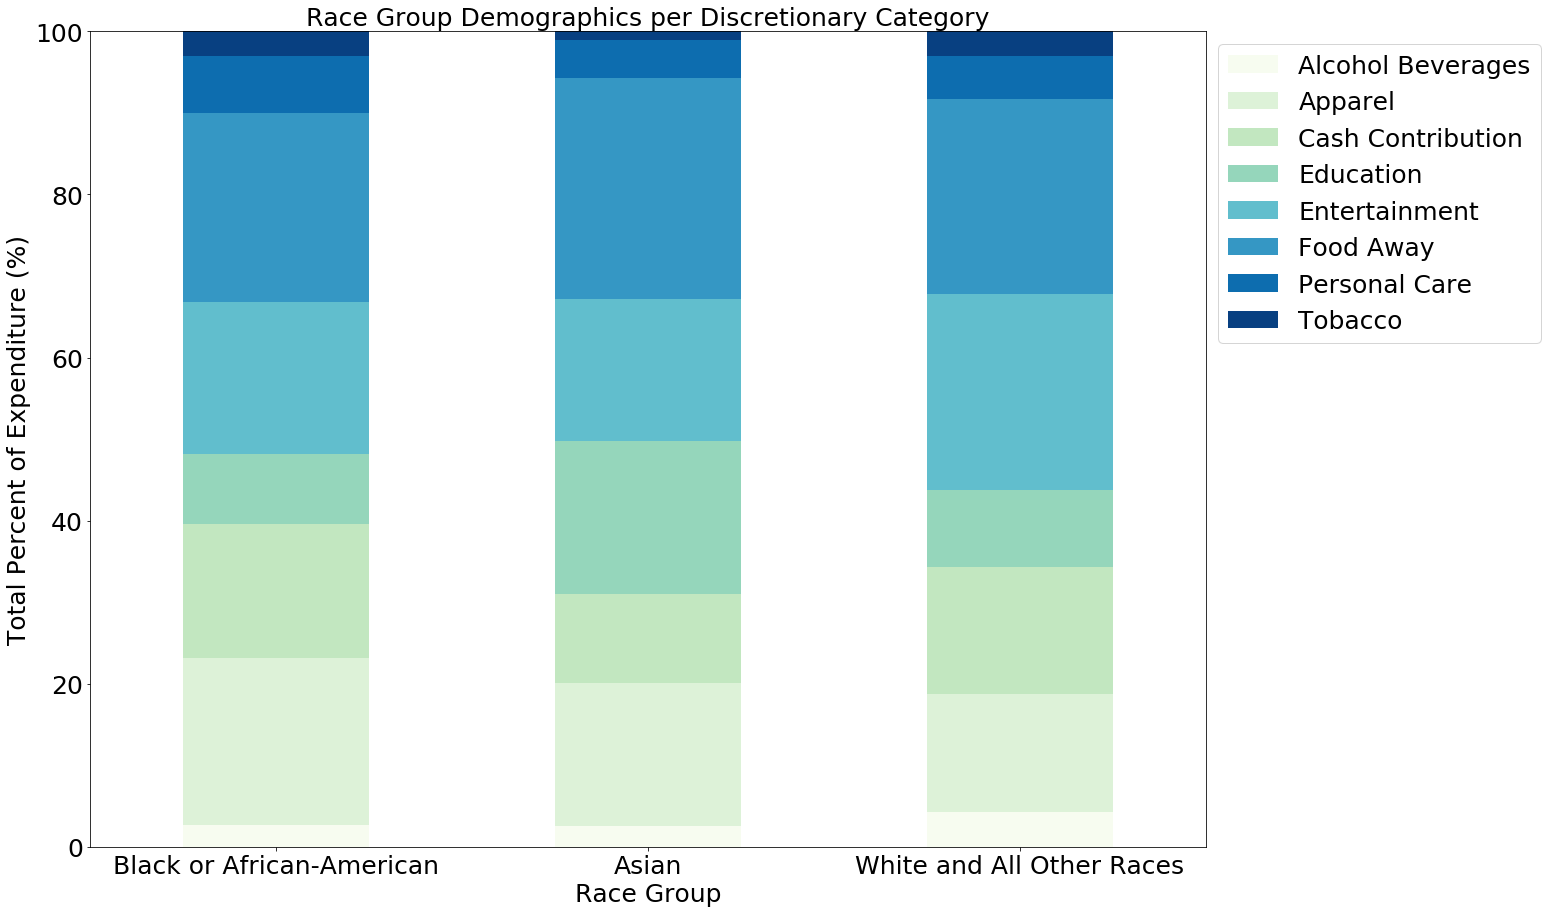

In [28]:
# Create stacked bar chart

# Compute the percentage 
race_df = race_df.div(race_df.sum(axis=1), axis=0) * 100

# Plot a stacked barchart
tocolor = (discretionary_labels)
colors = plt.get_cmap("GnBu", len(tocolor)) #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = race_df.plot.bar(stacked=True, figsize=(20,15), fontsize=25, colormap=colors)

# Place the legend
ax.legend(bbox_to_anchor=(1, 1), fontsize=25)
plt.xticks(rotation=0)
plt.ylim(0, 100) #CHANGE 100 TO 200000 FOR Y lABEL: VALUE ($)
plt.title('Race Group Demographics per Discretionary Category', fontsize=25)
plt.xlabel('Race Group', fontsize=25)
plt.ylabel('Total Percent of Expenditure (%)', fontsize=25)

# Save figure
plt.savefig('Images/spend_by_race.png')
plt.show()

In [ ]:
# Education Breakdown 

# EDUCATION COMPLETED: LESS THAN HIGH SCHOOL LB1303M
nohighschool_dict = {

    'CXUFOODAWAYLB1303M': 'FoodAway_AllRegions',
    'CXUAPPARELLB1303M': 'Apparel_AllRegions',
    'CXUENTRTAINLB1303M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB1303M': 'CashCont_AllRegions',
    'CXUALCBEVGLB1303M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB1303M': 'Edu_AllRegions',
    'CXUPERSCARELB1303M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB1303M': 'Tobacco_AllRegions',
}
        
df_nohighschool = json_df(nohighschool_dict)

# EDUCATION COMPLETED: HIGH SCHOOL LB1304M
highschool_dict = {
    'CXUFOODAWAYLB1304M': 'FoodAway_AllRegions',
    'CXUAPPARELLB1304M': 'Apparel_AllRegions',
    'CXUENTRTAINLB1304M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB1304M': 'CashCont_AllRegions',
    'CXUALCBEVGLB1304M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB1304M': 'Edu_AllRegions',
    'CXUPERSCARELB1304M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB1304M': 'Tobacco_AllRegions',
}
    

df_highschool = json_df(highschool_dict)

# EDUCATION COMPLETED: ASSOCIATE LB1306M
associate_dict = {
    'CXUFOODAWAYLB1306M': 'FoodAway_AllRegions',
    'CXUAPPARELLB1306M': 'Apparel_AllRegions',
    'CXUENTRTAINLB1306M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB1306M': 'CashCont_AllRegions',
    'CXUALCBEVGLB1306M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB1306M': 'Edu_AllRegions',
    'CXUPERSCARELB1306M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB1306M': 'Tobacco_AllRegions',
}

df_associate = json_df(associate_dict)

# EDUCATION COMPLETED: BACHELORS LB1308M
bachelors_dict = {
    'CXUFOODAWAYLB1308M': 'FoodAway_AllRegions',
    'CXUAPPARELLB1308M': 'Apparel_AllRegions',
    'CXUENTRTAINLB1308M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB1308M': 'CashCont_AllRegions',
    'CXUALCBEVGLB1308M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB1308M': 'Edu_AllRegions',
    'CXUPERSCARELB1308M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB1308M': 'Tobacco_AllRegions',
}

df_bachelors = json_df(bachelors_dict)

# EDUCATION COMPLETED: PROFESSIONAL, MASTER'S, DOCTORATE LB1309M
professional_dict = {
    'CXUFOODAWAYLB1309M': 'FoodAway_AllRegions',
    'CXUAPPARELLB1309M': 'Apparel_AllRegions',
    'CXUENTRTAINLB1309M': 'Entertainment_AllRegions',
    'CXUCASHCONTLB1309M': 'CashCont_AllRegions',
    'CXUALCBEVGLB1309M': 'Alcohol_AllRegions',
    'CXUEDUCATNLB1309M': 'Edu_AllRegions',
    'CXUPERSCARELB1309M': 'PersonalCare_AllRegions',
    'CXUTOBACCOLB1309M': 'Tobacco_AllRegions',
}

df_professional = json_df(professional_dict)


In [ ]:
#Set list for each Education value to store totals for each category (alphabetized)

#Grab Values for Age Groups
Nohs = get_total(df_nohighschool)
Highschool = get_total(df_highschool)
Associate = get_total(df_associate)
Bachelor = get_total(df_bachelors)
Professional = get_total(df_professional)


# EDUCATION DF
name=['Less than High School', 'High School', 'Associate', 'Bachelor', 'Professional']
edu_df = pd.DataFrame(data=[Nohs, Highschool, Associate, Bachelor, Professional],
                      columns=['Alcohol', 'Apparel', 'CashCont', 'Education', 'Entertainment', 'FoodAway',
                               'PersCare', 'Tobacco'])
edu_df["Education Completed"] = name
edu_df.set_index("Education Completed", drop=True, inplace=True)
edu_df

In [ ]:
# Create stacked bar chart

# Compute the percentage 
edu_df = edu_df.div(edu_df.sum(axis=1), axis=0) * 100

# Plot a stacked barchart
tocolor = (discretionary_labels)
colors = plt.get_cmap("GnBu", len(tocolor)) #CHANGE THIS TO EDIT COLORS. SEE CMAP COLOR FORMATS, https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
ax = age_df.plot.bar(stacked=True, figsize=(20,15), fontsize=25, colormap=colors)

# Place the legend
ax.legend(bbox_to_anchor=(1, 1), fontsize=25)
plt.xticks(rotation=0)
plt.ylim(0, 100) #CHANGE 100 TO 200000 FOR Y lABEL: VALUE ($)
plt.title('Education Level per Discretionary Category', fontsize=25)
plt.xlabel('Education Group', fontsize=25)
plt.ylabel('Total Percent of Expenditure (%)', fontsize=25)
plt.show()
plt.savefig('Images/spend_by_education.png')